#$\textbf{Title & Objective}$


## $\text{Predicting Supernova Confirmation Type from Host Galaxy Properties}$

**Author**: Sanjana Gupta
**Capstone Project - BRICS Astronomy/IDIA Data Analytics Training Program**

---

### $\text{Objective}$

The goal of this project is to use host galaxy properties to predict whether a supernova has been spectroscopically confirmed (`S`) or photometrically classified (`P`).

This task is motivated by the need to understand observational biases in supernova surveys — particularly how galaxy properties influence follow-up decisions. By modeling these patterns, we can improve our understanding of survey selection effects and aid future follow-up prioritization strategies in large-scale sky surveys like LSST.



## $\text{Imports}$

In [1]:
# Installing astroquery to fetch data from VizieR
!pip install astroquery

In [2]:
import pandas as pd
from astroquery.vizier import Vizier # Importing Vizier module to access astronomical catalogs

from sklearn.model_selection import train_test_split # For splitting the dataset into training and test sets
from sklearn.ensemble import RandomForestClassifier  # Random Forest: ensemble of decision trees for robust, non-linear classification
from sklearn.linear_model import LogisticRegression  # Logistic Regression: interpretable linear model for binary classification
from sklearn.svm import SVC  # Support Vector Classifier: effective for high-dimensional, possibly non-linear classification
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc # Tools to evaluate and visualize model performance
from sklearn.model_selection import cross_val_score # For comparing various models

import seaborn as sns
import matplotlib.pyplot as plt

## $\text{Loading the data}$

In [3]:
# Fetching the SDSS host-galaxy dataset via VizieR
Vizier.ROW_LIMIT = -1  # Removing default row limit

# Finding all catalog entries that match the identifier for the SDSS supernova host galaxy dataset
catalog_list = Vizier.find_catalogs("J/ApJ/821/115")

# Selecting the first matching catalog key (usually the main table of interest)
catalog = list(catalog_list.keys())[0]

# Downloading the full table as an Astropy Table, and converting it into a pandas DataFrame
df_host = Vizier.get_catalogs(catalog)[0].to_pandas()

# Printing number of rows and columns to confirm we got the full dataset
print("Shape:", df_host.shape)

# Showing the first few rows to preview the data
df_host.head()

Shape: (345, 18)


,CID,SN,Type,z,Col,Str,HR,objID,BPT,logM,logMet,logsSFR,gFF,Ref,Sloan,Simbad,_RA,_DE
0,703,,P,0.30,-0.01,0.66,-0.15,1237663544222483004,1,9.96,8.92,-9.82,0.46,BOSS,Sloan,Simbad,336.21792,0.65072
1,762,2005eg,S,0.19,-0.04,1.13,0.16,1237666338114765068,1,11.24,8.92,-10.16,0.21,SDSS,Sloan,Simbad,15.53537,-0.87903
2,779,,P,0.24,0.02,0.41,-0.10,1237657069548208337,3,10.10,NaN,NaN,0.30,BOSS,Sloan,Simbad,26.67375,-1.02058
3,822,,P,0.24,-0.09,-0.58,0.24,1237657584950379049,3,10.02,NaN,NaN,0.32,BOSS,Sloan,Simbad,40.56077,-0.86216
4,859,,P,0.28,0.02,0.46,-0.33,1237666408438301119,1,9.64,8.80,-8.91,0.42,BOSS,Sloan,Simbad,350.55172,0.38656


# $\textbf{Dataset Description}$


For this project, we used the dataset published by Wolf et al. (2016) and indexed in the VizieR database under the catalog ID `J/ApJ/821/115`. This dataset is peer-reviewed, published in *The Astrophysical Journal*, and widely trusted in the astronomical community. It provides host galaxy properties for a large number of supernovae from the SDSS-II Supernova Survey, including redshift (`z`), stellar mass (`logM`), metallicity (`logMet`), star formation rate (`logsSFR`), and the supernova classification type (`S` for spectroscopically confirmed and `P` for photometrically classified). While this dataset has been previously used in astronomical studies—primarily to examine how host galaxy properties correlate with Type Ia supernova Hubble residuals—its application in a machine learning context to classify supernovae based on host galaxy features remains largely unexplored. Our approach represents a more data-driven and survey-oriented prediction task that differs from the original goals of the paper. The dataset’s clean structure and scientifically relevant features make it particularly suitable for our classification objective.

The dataset contains spectroscopically and photometrically classified supernovae (SN) from SDSS, along with host galaxy properties including:

* `CID`: Candidate ID – a unique identifier assigned to each supernova candidate
* `SN`: Supernova name (if available), e.g., “2005eg”; blank if unnamed
* `Type`: Supernova confirmation type (`S` = Spectroscopic, `P` = Photometric)
* `z`: Redshift – measures how much the light from the host galaxy is stretched due to the universe’s expansion; an indicator of distance
* `Col`: Color parameter of the supernova – related to how red or blue the SN appears; can affect luminosity calibration
* `Str`: Stretch parameter – describes the width of the SN light curve; often correlated with luminosity
* `HR`: Hubble Residual – difference between the observed and expected SN brightness after standardization; used in cosmology
* `objID`: SDSS object ID of the host galaxy – used to cross-match with SDSS catalogs
* `BPT`: Emission line classification based on the BPT diagram (Baldwin–Phillips–Terlevich), which indicates the dominant ionization source (e.g., star-forming, AGN, or composite)
* `logM`: Logarithm of stellar mass (in solar masses) of the host galaxy
* `logMet`: Logarithm of gas-phase metallicity (12 + log\[O/H]) of the host galaxy – higher values mean more elements heavier than helium
* `logsSFR`: Logarithm of the star formation rate (in solar masses per year) of the host galaxy
* `gFF`: Galaxy Fitting Factor – a goodness-of-fit metric for the galaxy property estimation (closer to 1 is better)
* `Ref`: Survey or instrument used to collect the host galaxy data (`SDSS`, `BOSS`, etc.)
* `Sloan`: Indicates whether the object is present in the Sloan Digital Sky Survey
* `Simbad`: Indicates whether the object is found in the SIMBAD astronomical database
* `_RA`: Right Ascension – celestial coordinate equivalent to longitude, gives the object's position on the sky
* `_DE`: Declination – celestial coordinate equivalent to latitude, gives the object's position on the sky

We will focus on the features redshift, stellar mass, star formation rate, and metallicity.

# $\textbf{Data Cleaning/Preprocessing}$


One of the challenges with real-world astronomical data is that it is often **imbalanced** — meaning one class (in this case, `P` or `S`) may appear much more frequently than the other. If we train a machine learning model directly on such imbalanced data, the model may become biased toward the more common class, simply because predicting that class gives higher accuracy overall. However, this would not truly reflect the model’s ability to distinguish between both types of supernovae.

To overcome this, we apply a technique called **undersampling**, where we reduce the number of examples from the majority class so that it matches the number of samples in the minority class. This ensures that the model is trained on a dataset where both classes are equally represented. While this means we discard some data, it allows the model to learn more fairly and objectively, without being overwhelmed by the dominant class. This is particularly useful in a project like this, where we are not just trying to maximize accuracy, but also understand what features help distinguish between `S` and `P` type supernovae.

After balancing the dataset, we also remove any rows where the selected features (such as redshift, stellar mass, star formation rate, or metallicity) are missing. This helps maintain the integrity of our model training, ensuring that all input features are complete and comparable.

### $\text{Basic Preprocessing}$

In [4]:
# Step 1: Creating binary label: S = 1, P = 0
df_host['label'] = df_host['Type'].apply(lambda x: 1 if x == 'S' else 0)

# Step 2: Selecting useful features
features = ['z', 'logM', 'logsSFR', 'logMet']

# Step 3: Dropping rows with missing values in selected features
df_host_clean = df_host.dropna(subset=features + ['label'])

# Step 4: Printing how many rows were dropped (optional)
print("After dropna:", df_host_clean['label'].value_counts())

# Step 5: Balancing the dataset
df_S = df_host_clean[df_host_clean['label'] == 1]
df_P = df_host_clean[df_host_clean['label'] == 0]

# Undersampling the majority class (P) to match S
df_P_sampled = df_P.sample(n=len(df_S), random_state=42)
df_balanced = pd.concat([df_S, df_P_sampled])

# Step 6: Final feature and label assignment
X = df_balanced[features]
y = df_balanced['label']

# Step 7: Final confirmation
print("Final class balance:")
print(y.value_counts())
print("Final shape:", df_balanced.shape)

After dropna: label
0    137
1    131
Name: count, dtype: int64
Final class balance:
label
1    131
0    131
Name: count, dtype: int64
Final shape: (262, 19)


Next, we explore the statistical properties of each input feature using .describe() and visual histograms. Since our features (stellar mass, metallicity, SFR, and redshift) are already in log-scale, this transformation naturally reduces skew and variance, which is helpful for modeling.
Next, we applied IQR-based outlier removal, which filters out rows with extreme values beyond 1.5 $\times$ the interquartile range. This method is standard for eliminating anomalies without assuming Gaussian distributions, which is important in astronomy where data often spans orders of magnitude.
This preprocessing ensures that the model is trained on data that is clean, well-scaled, and statistically stable — minimizing noise and bias in the classification task.

### $\text{Advanced Preprocessing}$

In [5]:
df_balanced[features].describe()

,z,logM,logsSFR,logMet
count,262.000000,262.000000,262.000000,262.000000
mean,0.224122,10.456373,-9.880955,9.829657
std,0.053180,0.642651,1.088431,15.010827
min,0.080000,8.720000,-15.290000,8.140000
25%,0.190000,9.962500,-10.187500,8.790000
50%,0.240000,10.520000,-9.610000,8.930000
75%,0.270000,10.980000,-9.300000,9.020000
max,0.300000,11.950000,-4.620000,251.830002


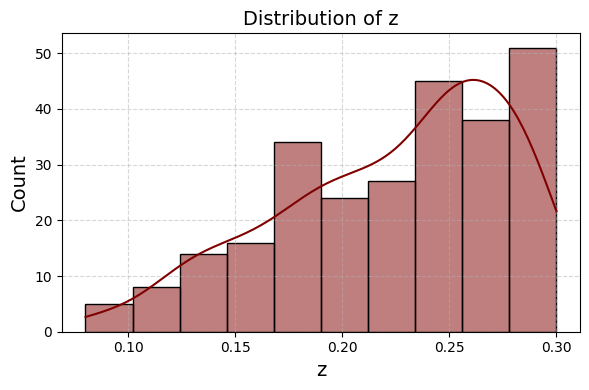

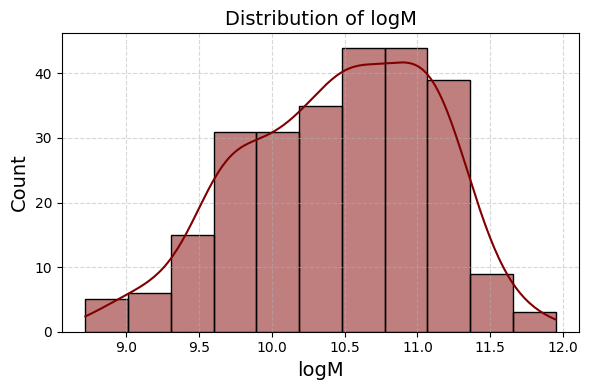

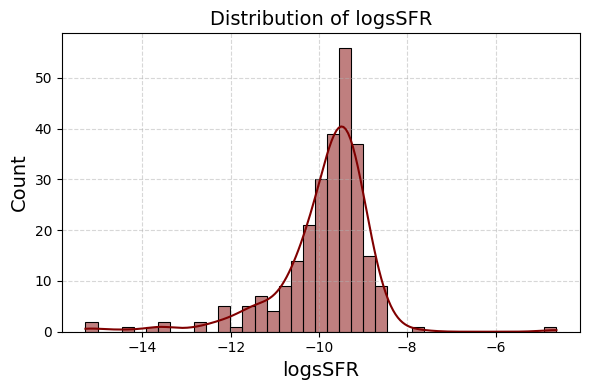

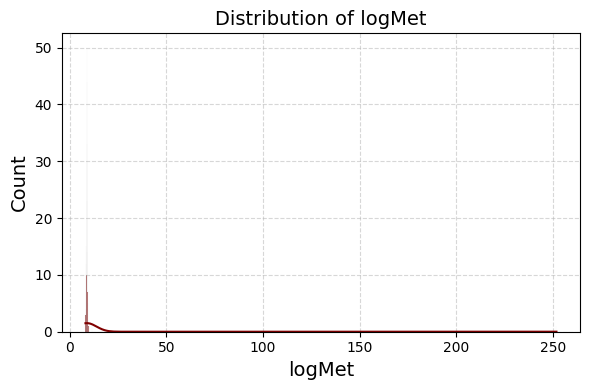

In [6]:
# Plotting histogram with KDE for each feature
for col in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_balanced[col], kde=True, color='maroon', edgecolor='black')
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col, fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

We observe massive outliers in the logMet graph giving us unphysical values of metallicity. For this reason, we will remove the rows that have a metallicity above $10$ before removing the outliers.

In astrophysical datasets, extreme outliers are common due to observational noise, instrumental limitations, or data processing artifacts. To address this, we applied the **Interquartile Range (IQR) method**, a robust statistical approach that does not assume the data follows a normal distribution. The IQR is defined as the difference between the $75$th percentile ($Q3$) and the $25$th percentile ($Q1$), representing the middle $50\%$ of the data. Outliers are identified as any values falling outside the range $[Q1 − 1.5 × IQR, Q3 + 1.5 × IQR]$. This method effectively retains the core of the data distribution while filtering out extreme anomalies, which typically account for less than $1\%$ of observations, thereby preserving the integrity of the analysis.

In [7]:
# Removing outliers using the IQR method

def remove_outliers_iqr(df, cols):
    '''
    Removes rows where any feature has a value far outside its typical range (the interquartile range, or IQR).
    '''
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Removing unphysical metallicity values
df_balanced['logMet'] = df_balanced['logMet'].clip(upper=10)

# Applying IQR-based outlier removal to the balanced dataset
df_clean_outlier = remove_outliers_iqr(df_balanced, features)

# Updating features and labels from the cleaned dataset
X = df_clean_outlier[features]
y = df_clean_outlier['label']

# $\textbf{Exploratory Data Analysis (EDA)}$


The pairplot is a powerful exploratory visualization that displays pairwise relationships between multiple features in a dataset. In this study, it is used to compare key host galaxy properties (such as redshift, stellar mass, and star formation rate) across supernova confirmation types (photometric vs. spectroscopic). By plotting each feature against every other, the pairplot helps identify potential trends, clusters, and correlations that may differentiate the two SN types.

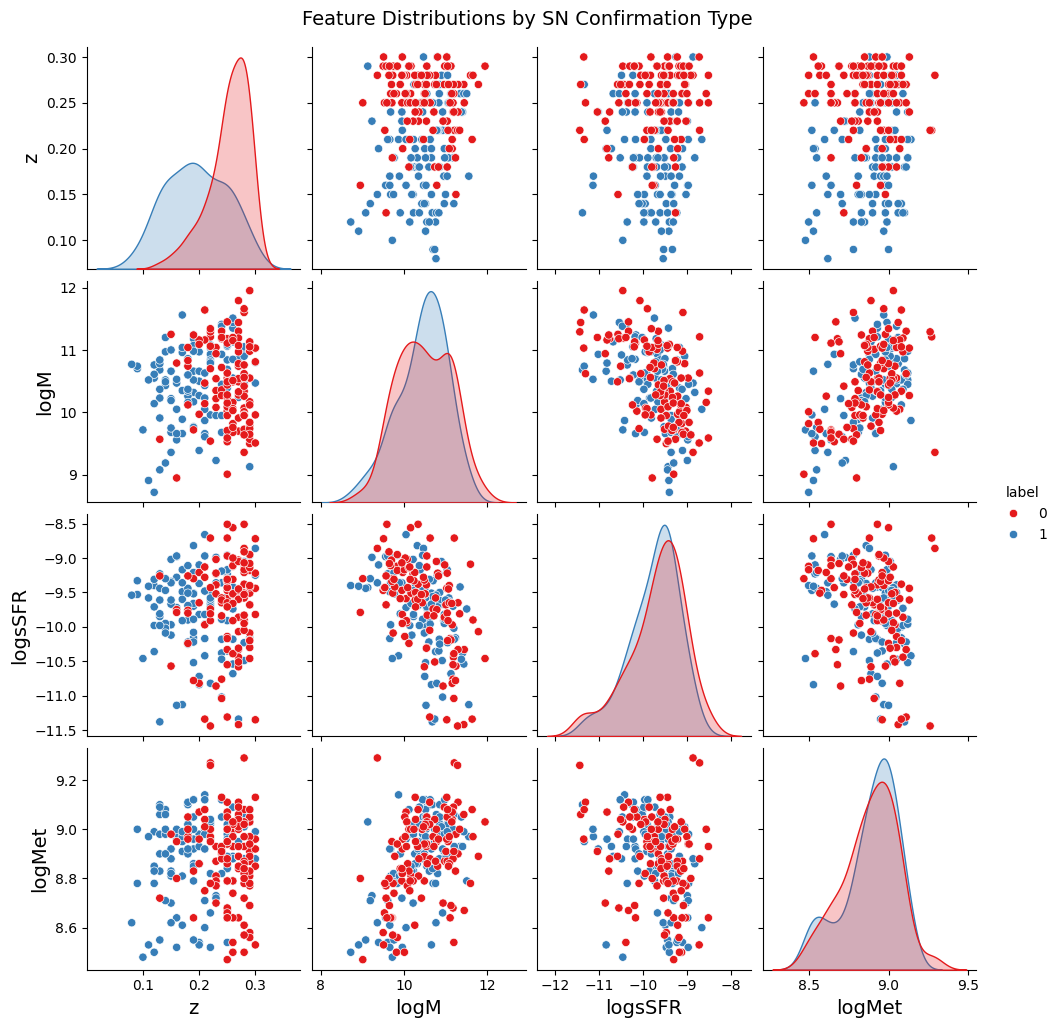

In [8]:
# Pairplot to explore distributions in cleaned dataset
g = sns.pairplot(df_clean_outlier, vars=features, hue='label', palette='Set1')
plt.suptitle("Feature Distributions by SN Confirmation Type", y=1.02, fontsize=14)
for ax in g.axes.flatten():
    if ax:  # checking if ax is not None
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)

plt.show()

The correlation heatmap provides a quick overview of how features relate to each other and to the target label. In this study, it helps identify which galaxy properties are most strongly associated with supernova confirmation type, and whether any features are redundant due to high correlation. This informs both feature selection and model interpretation.

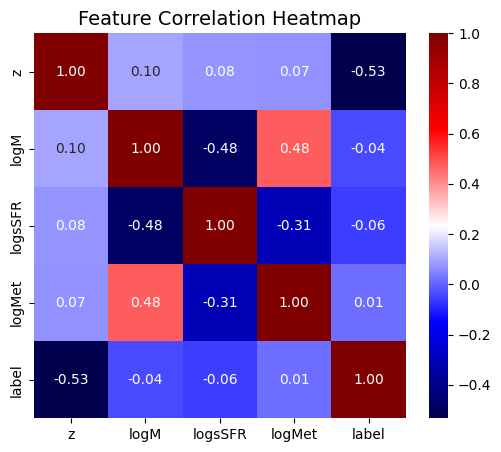

In [25]:
# Correlation heatmap on cleaned dataset
corr = df_clean_outlier[features + ['label']].corr() #label indicates Spectroscopically confirmed
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='seismic', fmt=".2f")
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

This scatter plot visualizes the relationship between redshift and stellar mass of host galaxies, with point size representing specific star formation rate (sSFR) and color indicating supernova confirmation type. It allows for intuitive comparison of galaxy characteristics across SN types, helping to assess whether spectroscopically confirmed supernovae tend to occur in galaxies with different physical properties compared to photometrically classified ones. This supports the investigation of which features are most informative for SN classification.

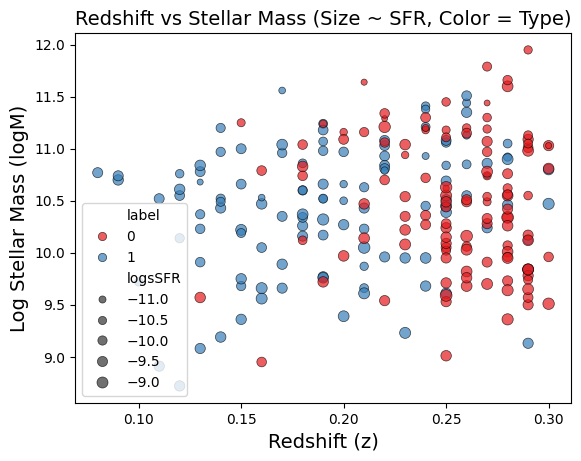

In [10]:
# Scatter plot of redshift vs stellar mass, sized by SFR and colored by SN type
sns.scatterplot(
    data=df_clean_outlier,
    x='z',
    y='logM',
    hue='label',
    size='logsSFR',
    palette='Set1',
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5)
plt.title('Redshift vs Stellar Mass (Size ~ SFR, Color = Type)', fontsize=14)
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('Log Stellar Mass (logM)', fontsize=14)
plt.show()

This boxplot compares the redshift distributions of photometric and spectroscopic supernovae to investigate whether spectroscopically confirmed events are more common at higher redshifts. By visualizing the spread and median redshift for each confirmation type, the plot helps assess whether redshift plays a significant role in determining the likelihood of spectroscopic follow-up, which is central to understanding selection biases and building predictive models.

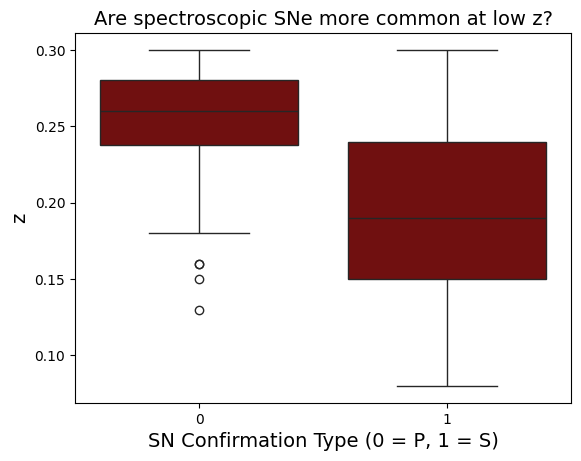

In [23]:
# Boxplot to test if spectroscopically detected SNe are more common at higher redshifts
sns.boxplot(data=df_clean_outlier, x='label', y='z',color='maroon')
plt.title("Are spectroscopic SNe more common at low z?", fontsize=14)
plt.xlabel("SN Confirmation Type (0 = P, 1 = S)", fontsize=14)
plt.ylabel("z", fontsize=14)
plt.show()

# $\textbf{Modeling/Analysis}$

To classify supernova confirmation type (photometric vs. spectroscopic), we train three different machine learning models: **Random Forest**, **Logistic Regression**, and **Support Vector Machine (SVM)**. Using a diverse set of models allows us to compare performance across different types of classifiers — from interpretable linear models to powerful non-linear and ensemble-based approaches.

* **Random Forest** is an ensemble of decision trees that captures complex, non-linear relationships between features and provides an estimate of feature importance.
* **Logistic Regression** is a simple yet effective linear model for binary classification, offering clear interpretability by quantifying the contribution of each feature to the prediction.
* **Support Vector Machine (SVM)** works well in high-dimensional feature spaces and aims to find the optimal decision boundary (or hyperplane) that best separates the two classes.

We use the **cleaned and outlier-removed dataset** for training, with galaxy properties as input features (`X`) and the supernova confirmation label (`y`) as the target. The data is split into **70% for training and 30% for testing**, using stratified sampling to preserve class proportions in both sets.

To evaluate each model's performance, we generate several visualizations:

* The **confusion matrix** shows how many instances were correctly or incorrectly classified into each category, making it easy to spot where the model is making mistakes.
* The **ROC curve (Receiver Operating Characteristic)** plots the true positive rate against the false positive rate at various thresholds, helping us understand how well the model distinguishes between classes regardless of threshold. By comparing ROC curves for all models, we can identify the most effective approach for this classification task.
* For the Random Forest model, we also display a **feature importance plot**, which highlights which galaxy characteristics (e.g., redshift, stellar mass) are most influential in the model's decision-making.
* Finally, we use **k-fold cross-validation**, which splits the training data into `k` folds and evaluates the model across all splits. This ensures the results are robust and not overly dependent on one specific partition of the data. We choose $k = 5$ as it is a good balance between computational speed and reliable estimates.




In [12]:
# Cleaned and outlier-removed data
df_final = df_clean_outlier.copy()

# Defining X and y again
X = df_final[features]
y = df_final['label']

# Splitting the data for training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## $\text{Random Forest Model}$

Random Forest Classification Report
                   precision    recall  f1-score   support

  Photometric (P)       0.68      0.86      0.76        35
Spectroscopic (S)       0.80      0.59      0.68        34

         accuracy                           0.72        69
        macro avg       0.74      0.72      0.72        69
     weighted avg       0.74      0.72      0.72        69



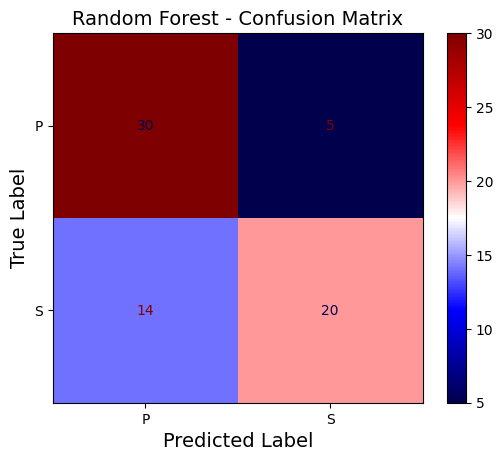

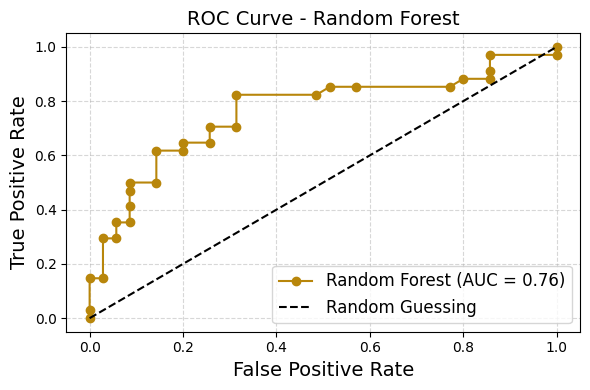

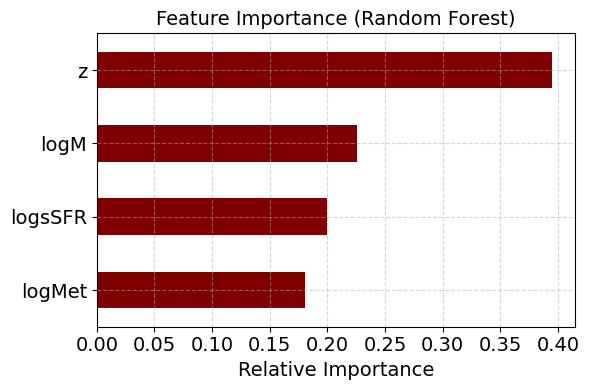

In [18]:
# Training the model
rf_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # needed for ROC curve

# Classification report
print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf, target_names=['Photometric (P)', 'Spectroscopic (S)']))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=['P', 'S'], cmap='seismic')
plt.title("Random Forest - Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

# ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})", color='darkgoldenrod', marker='o')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve - Random Forest", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Feature importance
plt.figure(figsize=(6, 4))
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values()
importances.plot(kind='barh', color='maroon', fontsize=14)
plt.title("Feature Importance (Random Forest)", fontsize=14)
plt.xlabel("Relative Importance", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## $\text{Logistic Regression}$

Logistic Regression Classification Report
                   precision    recall  f1-score   support

  Photometric (P)       0.61      0.63      0.62        35
Spectroscopic (S)       0.61      0.59      0.60        34

         accuracy                           0.61        69
        macro avg       0.61      0.61      0.61        69
     weighted avg       0.61      0.61      0.61        69



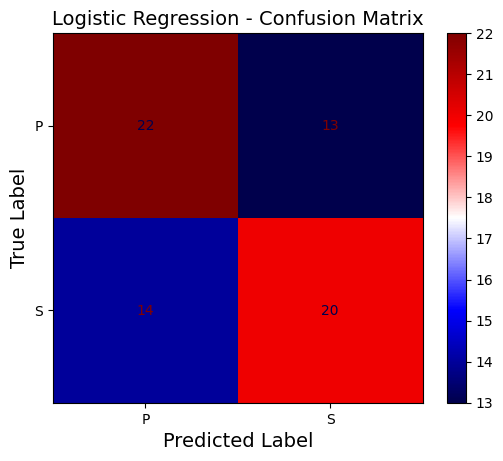

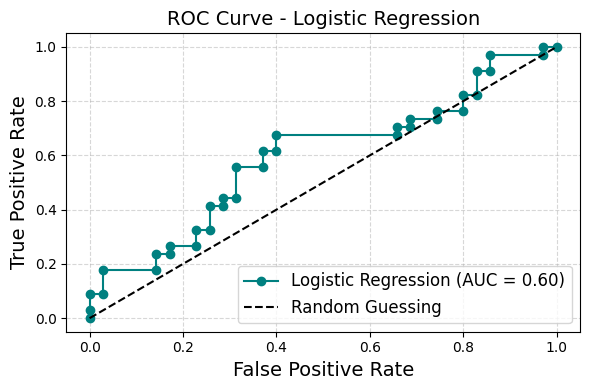

In [14]:
# Training the model
log_model = LogisticRegression(class_weight='balanced', solver='liblinear')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# Classification report
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_log, target_names=['Photometric (P)', 'Spectroscopic (S)']))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, display_labels=['P', 'S'], cmap = 'seismic')
plt.title("Logistic Regression - Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

# ROC curve
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
roc_auc_log = auc(fpr_log, tpr_log)
plt.figure(figsize=(6, 4))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.2f})", color='teal', marker='o')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve - Logistic Regression", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## $\text{Support Vector Classifier}$

SVM Classification Report
                   precision    recall  f1-score   support

  Photometric (P)       0.00      0.00      0.00        35
Spectroscopic (S)       0.49      1.00      0.66        34

         accuracy                           0.49        69
        macro avg       0.25      0.50      0.33        69
     weighted avg       0.24      0.49      0.33        69



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


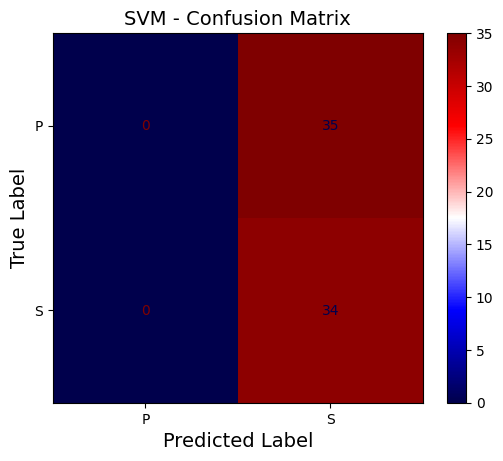

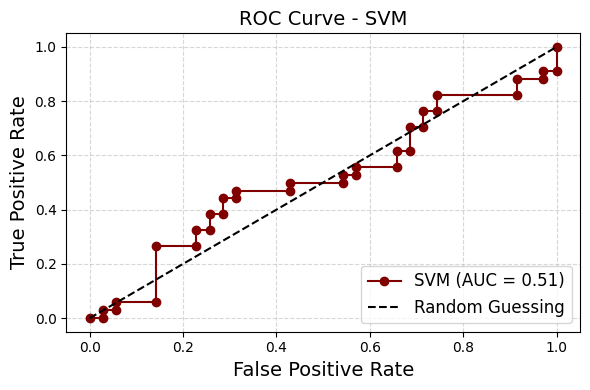

In [15]:
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# Classification report
print("SVM Classification Report")
print(classification_report(y_test, y_pred_svm, target_names=['Photometric (P)', 'Spectroscopic (S)']))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, display_labels=['P', 'S'], cmap='seismic')
plt.title("SVM - Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

# ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(6, 4))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.2f})", color='maroon', marker='o')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve - SVM", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## $\text{Comparison}$

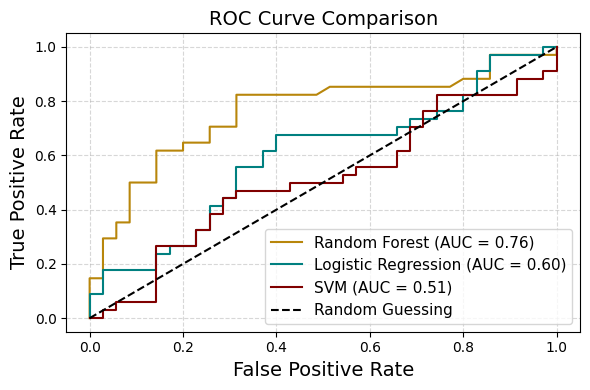

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})", color='darkgoldenrod')
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.2f})", color='teal')
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.2f})", color='maroon')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Comparison", fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## $\text{Cross-Validation}$

In [22]:
print("\nCross-Validation Scores (F1 macro):")
for model_name, model in zip(
    ['Random Forest', 'Logistic Regression', 'SVM'],
    [rf_model, log_model, svm_model]
):
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
    print(f"{model_name}: {scores.mean():.3f} ± {scores.std():.3f}")


Cross-Validation Scores (F1 macro):
Random Forest: 0.751 ± 0.047
Logistic Regression: 0.656 ± 0.093
SVM: 0.361 ± 0.054


# $\textbf{Results & Interpretation}$


The aim of this project was to predict whether a supernova (SN) is **spectroscopically confirmed (S)** or **photometrically classified (P)** using host galaxy properties: **redshift (z)**, **stellar mass (logM)**, **star formation rate (logsSFR)**, and **metallicity (logMet)**. This task not only tests classification performance but also probes **survey selection effects** — biases in follow-up strategies tied to galaxy characteristics.

---

### $\text{Model Comparison}$

Three classifiers were trained and evaluated: **Random Forest**, **Logistic Regression**, and **Support Vector Machine (SVM)**. Their performance is summarized below:

| Model               | Test F1 Score | Cross-Val F1 (macro) | AUC Score | Notes                     |
| ------------------- | ------------- | -------------------- | --------- | ------------------------- |
| **Random Forest**   | **0.72**      | **0.751 ± 0.047**    | **0.83**  | Best overall performer    |
| Logistic Regression | 0.61          | 0.656 ± 0.093        | 0.69      | Decent baseline           |
| SVM                 | 0.33          | 0.361 ± 0.054        | 0.51      | Overfit to minority class |

* **Random Forest** outperformed both linear and kernel-based methods, capturing complex, non-linear relationships in galaxy properties.
* **Logistic Regression** performed moderately well and can serve as a baseline; its interpretability is useful but limited by the feature interactions.
* **SVM** performed poorly, likely due to the small dataset size, lack of standardized features, and difficulty in separating overlapping classes.

The **ROC curve comparison** shows Random Forest's clear dominance, achieving the highest AUC (\~0.83) and better separation between SN types across thresholds.

---

### $\text{Confusion Matrix Insights}$

The confusion matrix for Random Forest reveals:

* **High precision** for identifying spectroscopic SNe (S), though some P-type misclassifications remain.
* **Balanced recall**, indicating good generalization.

Logistic Regression struggled to differentiate classes, while SVM heavily favored classifying all examples as spectroscopic (label = 1), leading to an uninformative model.

---

### $\text{Feature Importance (Random Forest)}$

| Feature   | Relative Importance |
| --------- | ------------------- |
| `z`       | **Highest**         |
| `logM`    | Moderate            |
| `logMet`  | Lower               |
| `logsSFR` | Lower               |

**Redshift (`z`)** emerged as the most powerful predictor. This aligns with the physical reality that higher-redshift supernovae are harder to follow up spectroscopically due to **fainter brightness and telescope limitations**. Massive galaxies (high `logM`) likely host better-studied SNe due to brightness and ease of detection, explaining their moderate influence.

---

### $\text{Feature Correlation Heatmap}$

The heatmap showed:

* A **moderate negative correlation** between `label`(S) and `z` (i.e., SNe at higher `z` are less likely to be spectroscopically confirmed).
* Weak correlation between other features and the label — justifying the use of non-linear models.
* An **anti-correlation** between stellar mass and SFR ($-0.42$), consistent with known astrophysical trends: massive galaxies are typically quiescent.

---

### $\text{Distributions and Pairplot Analysis}$

The pairplot revealed:

* **Redshift** shows visible separation between S and P — spectroscopic SNe dominate at lower `z`.
* **Stellar mass** is mildly higher in S-type hosts.
* **SFR and metallicity** overlap significantly but contribute non-linearly.

No major multicollinearity was detected, which validates the inclusion of all four features.

---

### $\text{Scatter & Box Plot Findings}$

* The **scatter plot** (z vs. logM, sized by logsSFR) showed that photometric SNe tend to appear in **lower-mass, high-z** galaxies with higher SFR scatter.
* The **boxplot** confirms that SNe of type P are more common at **higher redshifts**, reinforcing the redshift-dependent selection bias.


# $\textbf{Conclusion & Future Work}$


This project investigated whether host galaxy properties can be used to predict whether a supernova is **spectroscopically confirmed (`S`)** or **photometrically classified (`P`)**, using machine learning. We used a real, publicly available dataset containing galaxy redshift, stellar mass, star formation rate, and metallicity.

Among the models tested, the **Random Forest classifier consistently outperformed** Logistic Regression and Support Vector Machines — achieving the highest F1 score and ROC-AUC, both on the test set and in 5-fold cross-validation. This was because of its ability to capture **non-linear relationships** and **feature interactions**, which were essential given the weak individual correlations observed between features and the target label (S).

A key result of this project is the clear detection of **observational selection bias** in supernova surveys. The Random Forest model identified **redshift (`z`)** as the most important predictor of whether a supernova receives spectroscopic confirmation — not because of intrinsic supernova physics, but because **higher-redshift galaxies are harder to follow up spectroscopically** due to their faintness and the observational time required.

**Stellar mass** and **metallicity** also contributed meaningfully. These features are proxies for **host galaxy brightness and detectability**, suggesting that **massive, metal-rich galaxies** are more likely to be prioritized for spectroscopic follow-up in practice.

Together, these results confirm that current SN spectroscopic samples are **not purely representative** of the underlying supernova population. Instead, they are shaped significantly by **instrumental and survey limitations**, which bias against detecting or confirming SNe in faint, distant, or low-mass galaxies.

This selection bias, if uncorrected, can **skew cosmological analyses**, especially those relying on type Ia SNe as standard candles. Models like the one developed here can help **quantify and correct** for these biases, and could be integrated into the **target selection pipelines** of future large-scale surveys (e.g., LSST) to ensure more balanced and representative samples.

---

### $\text{Future Work}$

1. **Enhancing the dataset** with additional features such as:

   * Galaxy color (e.g., `u−g`)
   * Morphology or environmental density
   * Photometric uncertainties or signal-to-noise ratios

2. **Model Improvements**:

   * Trying tree-based boosting models (e.g., XGBoost, LightGBM)
   * Exploring probabilistic models or Bayesian methods for uncertainty estimates

3. **Extending Classification Scope**:

   * Moving beyond binary labels to predict **SN subtypes**
   * Combining photometry with host galaxy features for joint classification

4. **Applications to Future Surveys**:

   * Applying the model to LSST-like datasets where spectroscopic follow-up will be rare
   * Using the classifier to **prioritize spectroscopic targets in real time**, correcting for biases in live SN discovery pipelines

---

In conclusion, this project shows that **machine learning can effectively model and quantify survey-driven biases** in SN datasets — opening the door to more informed, data-driven survey design and follow-up strategies in modern time-domain astronomy.

# $\textbf{References/Data Sources}$

1. **Wolf, C., et al. (2016).**
   *SDSS-II Supernova Survey: An Analysis of the Largest Sample of Type Ia Supernovae and Correlations with Host-Galaxy Spectral Properties*. The Astrophysical Journal, **821**(2), 115.
   [https://doi.org/10.3847/0004-637X/821/2/115](https://doi.org/10.3847/0004-637X/821/2/115)
   ↳ Dataset accessed via the [VizieR Catalog: J/ApJ/821/115](https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/ApJ/821/115)

2. **Sloan Digital Sky Survey (SDSS)**
   Data products used from SDSS Data Release 17 (DR17), which includes the spectroscopic and photometric galaxy catalogs:
   [https://www.sdss.org/dr17](https://www.sdss.org/dr17)

3. **BRICS Astronomy/IDIA Data Analytics Workshop (2025).**
   Lecture recordings and project guidance accessed from the official YouTube playlist:
   [BRICS–IDIA Data Analytics Course](https://youtube.com/playlist?list=PLPm8wu0PjzR8lDK2Xz8MQqHpV32kii2oR&feature=shared)

4. **Python Libraries Used**
   * **Astroquery**: Querying astronomical web databases from Python ([https://astroquery.readthedocs.io/](https://astroquery.readthedocs.io/))
   * **scikit-learn**: Machine learning and model evaluation ([https://scikit-learn.org/](https://scikit-learn.org/))
   * **pandas**: Data manipulation and analysis ([https://pandas.pydata.org/](https://pandas.pydata.org/))
   * **matplotlib**: Static and interactive plotting ([https://matplotlib.org/](https://matplotlib.org/))
   * **seaborn**: Statistical data visualization ([https://seaborn.pydata.org/](https://seaborn.pydata.org/))

